In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind
import json
import os

In [2]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [3]:
data = pd.read_csv(os.path.join(data_path,'clean_data.csv'))
data.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,MRM Transition of each lipid species\n(Parent ion / Fragment ion),Lipid Species used as Internal Standard,Retention Time (min),Peak Area of Lipid Species,Peak Area of Internal Standard,Normalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue Weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,675.5 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.737513,4.116176e+06,4.165659e+07,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,703.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.662914,2.433723e+07,4.165659e+07,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,731.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.580159,1.432478e+08,4.165659e+07,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,729.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.572303,1.268323e+08,4.165659e+07,0.046320
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,759.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.486523,5.419340e+06,4.165659e+07,0.001167


In [4]:
data_pivot = data.pivot(index=['Sample Name', 'Sex', 'Treatment', 'PND', 'Tissue Type', 'Sample Submission Date'], columns='Individual Lipid Species', values=data.columns[16])
tot_lipids = data_pivot.shape[1] - 6
data_stats = data_pivot.reset_index().dropna(axis=1, thresh=0.9*data_pivot.shape[0]).fillna(0)
# data_stats.drop(columns=['Individual Lipid Species'])
data_stats.head()
lipids_ok = list(data_stats.columns[6:])

In [5]:
data_stats['Sample Submission Date'] = LabelEncoder().fit_transform(data_stats['Sample Submission Date'])
data_stats['Treatment'] = LabelEncoder().fit_transform(data_stats['Treatment'])
data_stats['Sample Submission Date'].unique()

array([0, 1])

In [6]:
data_np = data_stats.values[:,6:] + 1e-10
data_np = np.log(data_np.astype('float64'))
print(data_np.shape)

(72, 372)


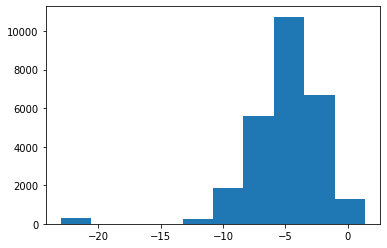

In [7]:
plt.figure()
plt.hist(data_np.flatten())
plt.show()

In [8]:
pca = PCA()
data_norm = StandardScaler().fit_transform(data_np)
data_pca = pca.fit_transform(data_norm)
print(data_pca.shape)

(72, 72)


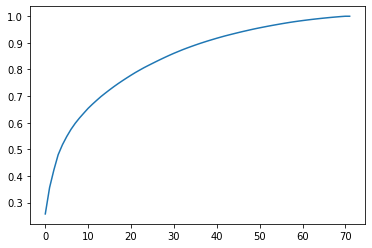

In [9]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [10]:
p_values = [
    [
        d,
        ttest_ind(data_pca[data_stats['Sample Submission Date']==0, d], data_pca[data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pca[data_stats['Treatment']==0, d], data_pca[data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pca.shape[1])
]
p_values = np.asarray(p_values)
print(p_values.shape)

(72, 3)


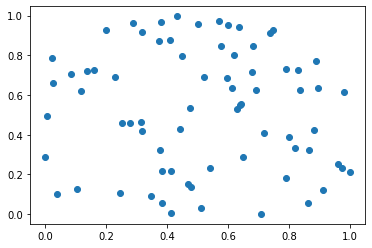

In [11]:
plt.figure()
plt.plot(p_values[:,1], p_values[:,2],'o')
plt.show()

In [12]:
print(f'{np.sum(p_values[:,1]<0.05)} significant pc with respect to date')
print(f'{np.sum(p_values[:,2]<0.05)} significant pc with respect to treatment')
print(f'{np.sum((p_values[:,2]<0.05)*(p_values[:,1]<0.05))} significant pc with respect to both')

significant_pc = np.where(p_values[:,2]<0.05)[0]

5 significant pc with respect to date
3 significant pc with respect to date
0 significant pc with respect to both


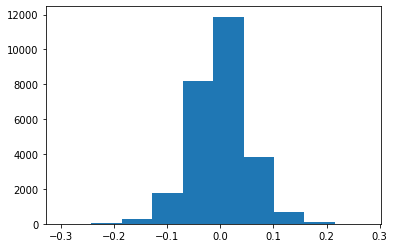

0.10525850730551864


In [13]:
plt.figure()
plt.hist(pca.components_.flatten())
plt.show()
ths = np.percentile(np.abs(pca.components_.flatten()), 95)
print(ths)

In [14]:
significant_components = pca.components_[significant_pc,:]
print(significant_components.shape)
max_values = np.max(np.abs(significant_components), axis=0)
print(max_values.shape)

(3, 372)
(372,)


In [15]:
idx_significant_lipids = np.where(max_values>ths)[0]
n_significant_lipids = len(idx_significant_lipids)
print(f'{n_significant_lipids} ({n_significant_lipids/tot_lipids*100:.2f}% of original total) significant lipids found')

55 (6.44% of original total) significant lipids found


In [16]:
with open('significant_lipids.txt','w') as f:
    for i in idx_significant_lipids:
        f.write(lipids_ok[i]+'\n')